# Implémentez un modèle de scoring :

In [1]:
#Importation des bibliothèques

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir

In [2]:
# Paramètres d'affichage des dataframes

pd.set_option('max_columns', None)
#pd.set_option('display.max_colwidth', None)
#pd.reset_option('^display.', silent=True)

In [3]:
# Récupération du fichier de travail

%store -r app_train

## On travaille sur le fichier app_train : 

## Observation du déséquilibre de la classe Target :

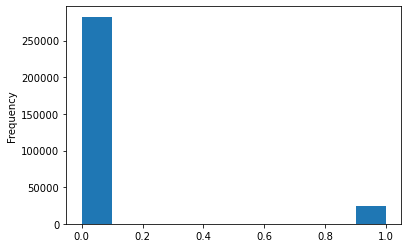

In [4]:
ax = app_train['TARGET'].plot.hist(bins=10)

In [5]:
taille_0 = app_train['TARGET'].value_counts()[0]
taille_1 = app_train['TARGET'].value_counts()[1]
ratio = taille_0 / taille_1
ratio_prct = taille_1/taille_0*100

print('Le fichier train possède',taille_1,'élements, alors que le fichier test en possède',taille_0)
print('Le fichier train est',ratio,' fois plus grand que le fichier test')
print('Les valeurs 1 représentent',ratio_prct,'% de la totalité des valeurs')
print('Les deux fichiers sont déséquilibrés et peuvent donc créer des résultats faussés dans l\'apprentissage d\'algorithmes supervisés')


Le fichier train possède 24825 élements, alors que le fichier test en possède 282682
Le fichier train est 11.386988922457201  fois plus grand que le fichier test
Les valeurs 1 représentent 8.781952865764357 % de la totalité des valeurs
Les deux fichiers sont déséquilibrés et peuvent donc créer des résultats faussés dans l'apprentissage d'algorithmes supervisés


## Normalisation des données

In [6]:
list_col = []

for col in app_train.columns :
    list_col.append(col)

In [7]:
#Sans distinction de varaibles

app_train_norm = app_train.copy()

for col in list_col :
    app_train_norm[col] = (app_train[col]-app_train[col].mean())\
                                    /app_train[col].std()

## Définition d'une baseline avec DummyClassifier (avant rééchantillonage)

### Définition des variables de travail/cible 

In [8]:
app_train.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Groupofpeople,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spousepartner,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Maternityleave,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academicdegree,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Coopapartment,NAME_HOUSING_TYPE_Houseapartment,NAME_HOUSING_TYPE_Municipalapartment,NAME_HOUSING_TYPE_Officeapartment,NAME_HOUSING_TYPE_Rentedapartment,NAME_HOUSING_TYPE_Withparents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaningstaff,OCCUPATION_TYPE_Cookingstaff,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_ITstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Privateservicestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Securitystaff,OCCUPATION_TYPE_Waitersbarmenstaff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_BusinessEntityType1,ORGANIZATION_TYPE_BusinessEntityType2,ORGANIZATION_TYPE_BusinessEntityType3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industrytype1,ORGANIZATION_TYPE_Industrytype10,ORGANIZATION_TYPE_Industrytype11,ORGANIZATION_TYPE_Industrytype12,ORGANIZATION_TYPE_Industrytype13,ORGANIZATION_TYPE_Industrytype2,ORGANIZATION_TYPE_Industrytype3,ORGANIZATION_TYPE_Industrytype4,ORGANIZATION_TYPE_Industrytype5,ORGANIZATION_TYPE_Industrytype6,ORGANIZATION_TYPE_Industrytype7,ORGANIZATION_TYPE_Industrytype8,ORGANIZATION_TYPE_Industrytype9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_LegalServices,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_SecurityMinistries,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Tradetype1,ORGANIZATION_TYPE_Tradetype2,ORGANIZATION_TYPE_Tradetype3,ORGANIZATION_TYPE_Tradetype4,ORGANIZATION_TYPE_Tradetype5,ORGANIZATION_TYPE_Tradetype6,ORGANIZATION_TYPE_Tradetype7,ORGANIZATION_TYPE_Transporttype1,ORG

In [9]:
X = app_train.iloc[:,np.r_[3:173]] 
X_norm = app_train_norm.iloc[:,np.r_[3:173]] 

In [10]:
y = app_train.iloc[:,2]

### Split des données

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.25, random_state=0) #remplacer X par X_scale

### Modélisation

In [12]:
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
import sklearn

In [13]:
dm = DummyClassifier()
dm.fit(X_train, y_train)

baseline_error = np.sqrt(np.mean((dm.predict(X_test) - y_test) ** 2))
print(baseline_error)
#calcul erreur quadratique
#réference de performance du modèle, on va chercher à avoir un résultat inférieur,
#qui signifiera une meilleur cohérence avec la réalité

0.5851197114103505


In [14]:
pred = dm.predict(X_test)

In [15]:
from sklearn.metrics import fbeta_score
import matplotlib.pyplot as plt
from sklearn import metrics, svm

print('BASELINE :')
#print("RMSE (using numpy):", np.sqrt(np.mean((pred - y_test) ** 2)))
#print("RMSE (using sklearn):", sklearn.metrics.mean_squared_error(pred, y_test, squared=False))
print("R2 score: ", sklearn.metrics.r2_score(y_test, pred))
print("AUC score: ", roc_auc_score(y_test, pred))
print("FBeta-score :", fbeta_score(y_test, pred, average = 'binary', beta = 0.5))

BASELINE :
R2 score:  -0.5206005103150895
AUC score:  0.5
FBeta-score : 0.7059751721056233


In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[    0 26320]
 [    0 50557]]

True Positives(TP) =  0

True Negatives(TN) =  50557

False Positives(FP) =  26320

False Negatives(FN) =  0


In [17]:
set(pred)

{1}

## Rééchantillonage (SMOTE)

In [18]:
import imblearn

In [19]:
#from unbalanced_dataset import UnderSampler, OverSampler, SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot

# transform the dataset
oversample = SMOTE()
X_S, y_S = oversample.fit_resample(X, y)

In [20]:
# summarize the new class distribution
counter = Counter(y_S)
print(counter)

Counter({0: 202448, 1: 202448})


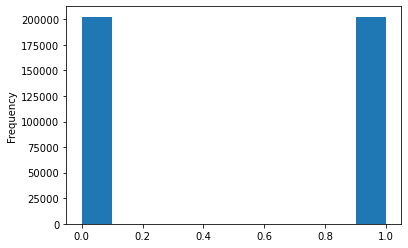

In [21]:
ax = y_S.plot.hist(bins=10)

## Définition d'une baseline avec DummyRegressor (après rééchantillonage sans normalisation)

### Split des données

In [22]:
from sklearn.model_selection import train_test_split
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_S, y_S, test_size=0.25, random_state=0) #remplacer X par X_scale

### Modélisation

In [23]:
dm = DummyRegressor()
dm.fit(X_train_S, y_train_S)

baseline_error = np.sqrt(np.mean((dm.predict(X_test_S) - y_test_S) ** 2))
print(baseline_error)
#calcul erreur quadratique
#réference de performance du modèle, on va chercher à avoir un résultat inférieur,
#qui signifiera une meilleur cohérence avec la réalité

0.5000001822555583


In [24]:
pred = dm.predict(X_test_S)
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1

In [25]:
print('BASELINE :')
print("AUC score: ", roc_auc_score(y_test_S, pred))
print("FBeta-score :", fbeta_score(y_test_S, pred, average = 'micro', beta = 0.5))

BASELINE :
AUC score:  0.5
FBeta-score : 0.4995159250770568


In [26]:
cm = confusion_matrix(y_test_S, pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[50563     0]
 [50661     0]]

True Positives(TP) =  50563

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  50661


## Définition d'une baseline avec DummyClassifier (après rééchantillonage avec normalisation)

### Normalisation des données rééchantillionnées

In [27]:
X_norm_SMOTE = X_S.copy()

for column in X_norm_SMOTE :
    X_norm_SMOTE[column] = (X_norm_SMOTE[column]-X_norm_SMOTE[column].mean())\
                                    /X_norm_SMOTE[column].std()

### Split des données

In [28]:
from sklearn.model_selection import train_test_split
X_train_NS, X_test_NS, y_train_NS, y_test_NS = train_test_split(X_norm_SMOTE, y_S, test_size=0.25, random_state=0) #remplacer X par X_scale

### Modélisation

In [29]:
dm = DummyRegressor()
dm.fit(X_train_NS, y_train_NS)

baseline_error = np.sqrt(np.mean((dm.predict(X_test_NS) - y_test_NS) ** 2))
print(baseline_error)
#calcul erreur quadratique
#réference de performance du modèle, on va chercher à avoir un résultat inférieur,
#qui signifiera une meilleur cohérence avec la réalité

0.5000001822555583


In [30]:
pred = dm.predict(X_test_NS)
pred[pred <= 0.5] = 0
pred[pred > 0.5] = 1

In [31]:
print('BASELINE :')
print("AUC score: ", roc_auc_score(y_test_NS, pred))
print("FBeta-score :", fbeta_score(y_test_NS, pred, average = 'micro', beta = 0.5))

BASELINE :
AUC score:  0.5
FBeta-score : 0.4995159250770568


In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_NS, pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[50563     0]
 [50661     0]]

True Positives(TP) =  50563

True Negatives(TN) =  0

False Positives(FP) =  0

False Negatives(FN) =  50661


## Modélisation avec LGBClassifier (is_unbalance : true)

On réduit la quantité de données pour que la durée de calcule devienne raisonable

In [33]:
X_train_10 = X_train.sample(frac = 0.001)
y_train_10 = y_train.sample(frac = 0.001)
X_test_10 = X_test.sample(frac = 0.001)
y_test_10 = y_test.sample(frac = 0.001)

In [34]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [35]:
import lightgbm

In [36]:
oversample = SMOTE()
X_train_S_10, y_train_S_10 = SMOTE().fit_resample(X_train_10, y_train_10)
X_test_S_10, y_test_S_10 = SMOTE().fit_resample(X_test_10, y_test_10)

In [54]:
#défintion du classifier
lgbmc = LGBMClassifier()

#fit model
#Implémentation des données rééquilibrées 
lgbmc.fit(X_train_S_10, y_train_S_10)
#oversample = SMOTE()
#lgbmc.fit(oversample.fit_resample(X_train_10, y_train_10))

#prediction
y_pred = lgbmc.predict(X_test_10)

#résultats
print(lgbmc.score(X_test_10, y_test_10))

0.5974025974025974


In [38]:
train_data = lightgbm.Dataset(X_train, label = y_train)
test_data = lightgbm.Dataset(X_test, label = y_test)

### Hyperparamètre searching

### 1er tour

In [61]:
#Définition du gridsearchCV
parametres = {
    'num_boost_round': np.arange(1, 10000, 500),#[1000, 2000, 3000],
    'num_leaves' : np.arange(1,100,10)#[30, 40, 50]
}

lgbmc = LGBMClassifier()

#Gridsearch
grid_search = GridSearchCV(lgbmc, param_grid=parametres, cv = 4, error_score=0)

grid_result = grid_search.fit(X_train_S_10, y_train_S_10)

#Mise en place des meilleurs paramètres
final_model = lgbmc.set_params(**grid_result.best_params_)

#Fit du meilleur model avec les données
final_model.fit(X_train_10, y_train_10)

#Prédiction pour le modèle final
y_pred = final_model.predict(X_test_10)

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py", line 890, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.p

[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


In [62]:
#MaxF1 = max(grid_search.cv_results_['mean_test_f1'])

print('best_params :', grid_search.best_params_)
#print('best F1 scpre :', MaxF1)

best_params : {'num_boost_round': 1001, 'num_leaves': 11}


In [63]:
#Vérification de la meilleure valeur de F1 Score
grid_search2 = GridSearchCV(lgbmc, param_grid=parametres, scoring=['f1'],refit = False, cv = 4, error_score=0)

grid_result = grid_search2.fit(X_train_S_10, y_train_S_10)

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=1, num_boost_round=1 will be ignored. Current value: num_iterations=1
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=501, num_boost_round=501 will be ignored. Current value: num_iterations=501
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001
[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1001, num_boost_round=1001 will be ignored. Current value: num_iterations=1001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501
[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=1501, num_boost_round=1501 will be ignored. Current value: num_iterations=1501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001
[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2001, num_boost_round=2001 will be ignored. Current value: num_iterations=2001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501
[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=2501, num_boost_round=2501 will be ignored. Current value: num_iterations=2501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001
[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3001, num_boost_round=3001 will be ignored. Current value: num_iterations=3001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501
[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=3501, num_boost_round=3501 will be ignored. Current value: num_iterations=3501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001
[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4001, num_boost_round=4001 will be ignored. Current value: num_iterations=4001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501
[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=4501, num_boost_round=4501 will be ignored. Current value: num_iterations=4501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001
[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5001, num_boost_round=5001 will be ignored. Current value: num_iterations=5001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501
[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=5501, num_boost_round=5501 will be ignored. Current value: num_iterations=5501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001
[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6001, num_boost_round=6001 will be ignored. Current value: num_iterations=6001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501
[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=6501, num_boost_round=6501 will be ignored. Current value: num_iterations=6501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001
[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7001, num_boost_round=7001 will be ignored. Current value: num_iterations=7001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501
[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=7501, num_boost_round=7501 will be ignored. Current value: num_iterations=7501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001
[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8001, num_boost_round=8001 will be ignored. Current value: num_iterations=8001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501
[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=8501, num_boost_round=8501 will be ignored. Current value: num_iterations=8501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001
[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9001, num_boost_round=9001 will be ignored. Current value: num_iterations=9001


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501
[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=9501, num_boost_round=9501 will be ignored. Current value: num_iterations=9501


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
80 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py", line 890, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.p

In [64]:
MaxF1 = max(grid_search2.cv_results_['mean_test_f1'])
print('best F1 score :', MaxF1)

best F1 score : 0.6305691721132898


### 2ème tour

In [65]:
parametres = {
    'num_boost_round': np.arange(50, 1000, 50),#[1000, 2000, 3000],
    'num_leaves' : np.arange(1,20,2)#[30, 40, 50]
}

lgbmc = LGBMClassifier()

#Gridsearch
grid_search = GridSearchCV(lgbmc, param_grid=parametres, cv = 4, error_score=0)

grid_result = grid_search.fit(X_train_S_10, y_train_S_10)

#Mise en place des meilleurs paramètres
final_model = lgbmc.set_params(**grid_result.best_params_)

#Fit du meilleur model avec les données
final_model.fit(X_train_10, y_train_10)

#Prédiction pour le modèle final
y_pred = final_model.predict(X_test_10)

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will b

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will b

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_ro

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, 

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in para

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
76 fits failed out of a total of 760.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.py", line 890, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/sklearn.p

In [66]:
print('best_params :', grid_search.best_params_)

best_params : {'num_boost_round': 250, 'num_leaves': 9}


In [67]:
#Vérification de la meilleure valeur de F1 Score
grid_search2 = GridSearchCV(lgbmc, param_grid=parametres, scoring=['f1'],refit = False, cv = 4, error_score=0)

grid_result = grid_search2.fit(X_train_S_10, y_train_S_10)

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will b

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=10

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=150, num_boost_round=150 will be ignored. Current value: num_iterations=150
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200
[LightGBM] [Warning] num_iterations is set=200, num_boost_round=200 will be ignored. Current value: num_iterations=200


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, 

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Wil

[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=250, num_boost_round=250 will be ignored. Current value: num_iterations=250
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=300, num_boost_round=300 will be ignored. Current value: num_iterations=300
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350
[LightGBM] [Warning] num_iterations is set=350, num_boost_round=350 will be ignored. Current value: num_iterations=350


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=400, num_boost_round=400 will be ignored. Current value: num_iterations=400
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))



[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=450, num_boost_round=450 will be ignored. Current value: num_iterations=450
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicol

[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550
[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=550, num_boost_round=550 will be ignored. Current value: num_iterations=550


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=600, num_boost_round=600 will be ignored. Current value: num_iterations=600
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650
[LightGBM] [Warning] num_iterations is set=650, num_boost_round=650 will be ignored. Current value: num_iterations=650


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700
[LightGBM] [Warning] num_iterations is set=700, num_boost_round=700 will be ignored. Current value: num_iterations=700


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/User

[LightGBM] [Warning] num_iterations is set=750, num_boost_round=750 will be ignored. Current value: num_iterations=750
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800
[LightGBM] [Warning] num_iterations is set=800, num_boost_round=800 will be ignored. Current value: num_iterations=800


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850
[LightGBM] [Warning] num_iterations is set=850, num_boost_round=850 will be ignored. Current value: num_iterations=850


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900
[LightGBM] [Warning] num_iterations is set=900, num_boost_round=900 will be ignored. Current value: num_iterations=900


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /tmp/pip-req-build-u3yb2eqd/compile/src/io/config_auto.cpp, line 324 .

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
[Ligh

[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950
[LightGBM] [Warning] num_iterations is set=950, num_boost_round=950 will be ignored. Current value: num_iterations=950


/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
76 fits failed out of a total of 760.
The score on these train-test partitions for these parameters will be set to 0.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
76 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/nicolas/opt/anaconda3

In [68]:
MaxF1 = max(grid_search2.cv_results_['mean_test_f1'])
print('best F1 scpre :', MaxF1)

best F1 scpre : 0.6537831733483906


On note une augmentation du score F1, qui indique une amélioration de la précision du modèle.

### Création du modèle avec les meilleurs paramètres

In [70]:
#défintion du classifier
parametres = {'objective' : 'binary', #probleme de classification, on cherche un résultat binaire
              'metric' : 'auc', #on utilise l'AUC comme métrique de mesure de perfomance du modèle
              'is_unbalance' : 'true', #distribution inégale des données cibles
              #'boosting' : 'gbdt', #gradient boosting decision tree (others :gbdt rf, dart, goss)
              'num_leaves' : 3, #default value
              'feature_fraction':1, #features selectionnées de manière aléatoire à chaque itération 
              'bagging_fraction':1, #selectionne une partie des données de manière fixe
              'bagging_freq':2, #change les données selectionnées précédement toutes les x ittérations
              'learning_rate':0.1, #shrikage rate, default value 
              'verbose':-1
               }

lgbmc = LGBMClassifier(objective = 'binary',
                       metric = 'auc',
                       is_unbalance = 'true', 
                       num_boost_round=50, #combien d'arbres
                        num_leaves=5)

#fit model
lgbmc.fit(X_train, y_train)

#prediction
y_pred = lgbmc.predict(X_test)

#résultats
print(lgbmc.score(X_test, y_test))

/Users/nicolas/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] num_iterations is set=50, num_boost_round=50 will be ignored. Current value: num_iterations=50
0.7754334846573098


In [71]:
print("AUC score: ", roc_auc_score(y_test, y_pred))
print("Predict probability", lgbmc.score(X_test, y_test))
print("FBeta-score :", fbeta_score(y_test, y_pred, average = 'binary', beta = 0.5))

AUC score:  0.7760672562817388
Predict probability 0.7754334846573098
FBeta-score : 0.8490521008257506


In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

In [ ]:
best_params = grid_search.best_params_

In [ ]:
%store best_params

## Récupération du meilleur modèle avec Pickle

In [ ]:
import pickle

In [ ]:

pickle.dump(lgbmc, open("../exemple_API/LGBM_best_model.pickle","wb"))

In [ ]:
X_test_pickle = X_test.sample(frac = 0.2)

In [ ]:
pickle.dump(X_test_pickle, open("../exemple_API/X_test_lgbm.pickle",'wb'))

In [ ]:
%store X_test_10

## Visualisation de la feature importance

In [ ]:
import shap

In [ ]:
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(lgbmc)
shap_values = explainer.shap_values(X_test)
# Summary plot
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[1], X_test, show=False)

In [ ]:
explainer = shap.Explainer(lgbmc, X_train)
shap_values = explainer(X_train, check_additivity=False)

In [ ]:
shap.plots.bar(shap_values, max_display=36)

### Implémentation des variabels probabilité et prediction pour l'affichage Web

In [ ]:
X_test_10

In [ ]:
probability = lgbmc.predict_proba(X_test_10)[:,1] #probabilité
prediction = lgbmc.predict(X_test_10) #prediction
     
output = pd.DataFrame({'prediction': prediction, 'probability': probability})

In [ ]:
X_test_10 = X_test_10.reset_index()
X_test_10 = X_test_10.join(output)
X_test_10

In [ ]:
X_test_10 = X_test_10.join(output)

In [ ]:
X_test_10['']

In [ ]:
X_test_10.to_csv('../exemple_API/X_test_10.csv')